<a href="https://colab.research.google.com/github/nehu7/Melonama_detection_CNN/blob/main/Melanoma_Detection_Assignment_Neha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color='blue'> Multiclass classification Model using CNN



#**<font color='red'> Problem statement**: 

> To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



>Dataset has 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.



### <font color='green'> Importing all the important libraries

In [1]:
# Import the required libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
from tensorflow import keras
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.utils import image_dataset_from_directory

### <font color='green'> Importing Skin Cancer Data

In [2]:
# Fetching ZIP data from drive and mounting it to colab and extracting the images
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab Notebooks/CNN_assignment.zip"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Colab Notebooks/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic

### <font color='green'> Importing train and test images

In [3]:
# Defining the path for train and test images
# Train dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

# Counting the number of images in train dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print ("Total images in train directory : ", image_count_train)

# Test dataset
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

# Counting the number of images in test dataset
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print ("Total images in test directory : ", image_count_test)

Total images in train directory :  2239
Total images in test directory :  118


### <font color='green'> Assigning batch size and resize info for images

In [4]:
batch_size = 32
img_height = 180
img_width = 180

### <font color='green'>Loading images using keras.preprocessing

Using 80% of the images for training, and 20% for validation.

In [5]:
# Creating train dataset using image_dataset_from_directory
train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Creating validation dataset from the train directory
val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### <font color='green'> Listing categories of cancer

In [6]:
# Listing out all the classes of skin cancer and storing them in the list in alphabetical order
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


###<font color='green'>Visualize the data

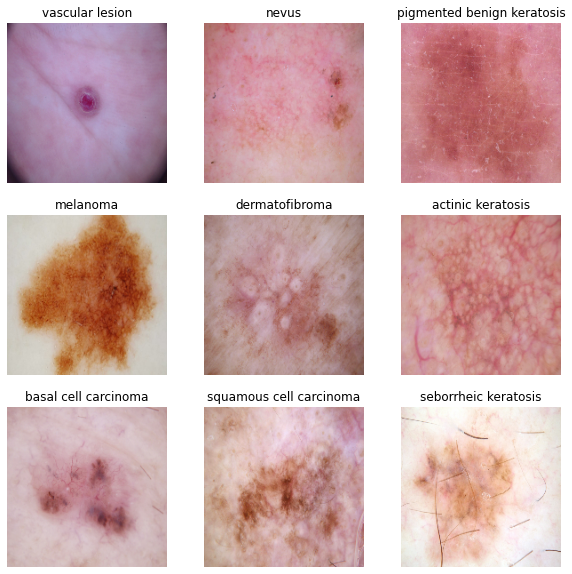

In [7]:
# Choosing the display the images in a grid size 3 X 3
plt.figure(figsize=(10, 10))

# Fetching the images and labels for 2 batches of images
# Assuming all images will be picked up in 2 batches
take_dataset_images = train_ds.take(2)

# Set is required to check if a particular image has already been visited from tf
visited_image_labels = set()

# Iterating over all the labels and plotting the image
# If an image is already plotted, it will skip to the next image
def plot_images(images, label, i, k):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[k].numpy().astype("uint8"))
  plt.title(class_names[label])
  plt.axis('off')

completed = False
i = 0
for l in range(2):
  images, labels = list(take_dataset_images)[l]
  k = 0
  for label in labels.numpy():
    if label in visited_image_labels:
      k+=1
      continue
    plot_images(images, label, i, k)
    visited_image_labels.add(label)
    if len(visited_image_labels) == 9:
      completed = True
      break
    k+=1
    i+=1
  if completed:
    break

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

#**<font color='red'> Model 1**


# <font color='green'> Model building - CNN
- Creating a CNN model, which can accurately detect 9 classes present in the dataset. 
- Used ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [9]:
# Rescaled normalised layer

normalisation_layer = keras.Sequential([Rescaling(1./255, input_shape=(img_height, img_width, 3))])
normalisation_layer

num_classes = len(class_names)

# Creating a baseline model with 5 convolution layers 
# each followed by a max-pooling layer
# fully-connected layers at the end

model = keras.Sequential()
model.add(normalisation_layer)

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# <font color='green'> Model compiling
Compiling the model using `adam` optimizer and `sparse_categorical_crossentropy` as a loss function. Using `accuracy` as a metric.

In [10]:
# Using adam optimiser to compile the model
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

# <font color='green'> Model training

In [11]:
# Training the model with 20 epochs each with a batch size of 32
epochs = 20
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True
)

Epoch 1/20
56/56 [==============================] - 28s 108ms/step - loss: 2.0088 - accuracy: 0.2344 - val_loss: 1.9179 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.8636 - accuracy: 0.2879 - val_loss: 1.7892 - val_accuracy: 0.3199
Epoch 3/20
56/56 [==============================] - 3s 49ms/step - loss: 1.6965 - accuracy: 0.3795 - val_loss: 1.6270 - val_accuracy: 0.4430
Epoch 4/20
56/56 [==============================] - 3s 49ms/step - loss: 1.6253 - accuracy: 0.4079 - val_loss: 1.5606 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.5224 - accuracy: 0.4738 - val_loss: 1.5627 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 3s 49ms/step - loss: 1.5090 - accuracy: 0.4749 - val_loss: 1.5278 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.4759 - accuracy: 0.4844 - val_loss: 1.5513 - val_accuracy: 0.4340
Epoch 8/20


# <font color='green'>Visualizing training results

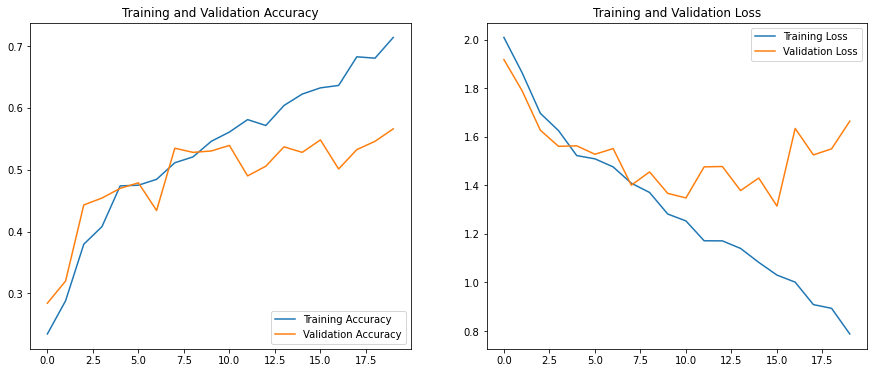

In [12]:
# Visualising the accuracy and loss between train and validation results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## <font color='lime'> Observations


*   The training and validation accuracy are diverging which indicates that the model tends to overfit with the baseline model
*   We can also see that due to overfitting, the loss also tend to diverge and starts increasing after 17th epoch which is `~1.37`
*   The above graph also shows the trend that training Loss continuously reduces whereas the validation loss starts increasing after a few epochs.



# <font color='green'> Data Augmentation
##### It acts as a regularizer and helps reduce overfitting when training a machine learning model.
##### This process will try to transform the image by resizing, zooming and flipping the image based on a random probability factor. This is very useful to generalise a model. Let's create a data augmentation layer and apply it to a particular image to see how it works.

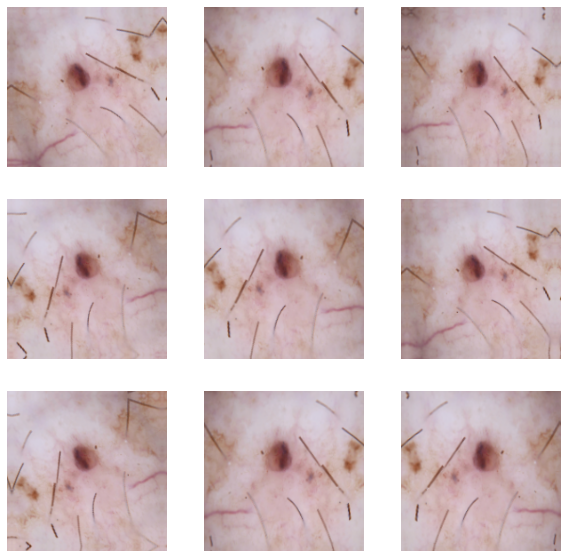

In [13]:
# Creating a data augmentation layer
# 1. RandomFlip : to flip the image horizontally
# 2. RandomRotation : Rotate the image
# 3. RandomZoom : Zoom the image
data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

# Visualizing how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#**<font color='red'> Model 2** 

# <font color='green'>  Augmented Model with dropout


In [14]:
# Creating an augmented model with the same number of convolution layers as the baseline model
# each followed by a max-pooling layer
# and fully-connected layers at the end

model = keras.Sequential()
model.add(normalisation_layer)
model.add(data_augmentation)

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# <font color='green'>  Compiling the model

In [15]:
# Using adam optimiser to compile the model
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

# View the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

# <font color='green'> Training the model

In [16]:
# Training the model with 20 epochs each with a batch size of 32
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True
)

Epoch 1/20
56/56 [==============================] - 6s 67ms/step - loss: 2.0752 - accuracy: 0.1908 - val_loss: 2.0931 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 61ms/step - loss: 2.0232 - accuracy: 0.2081 - val_loss: 1.9627 - val_accuracy: 0.2685
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 1.9609 - accuracy: 0.2634 - val_loss: 2.0046 - val_accuracy: 0.2192
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 1.8540 - accuracy: 0.3231 - val_loss: 1.7091 - val_accuracy: 0.3490
Epoch 5/20
56/56 [==============================] - 3s 61ms/step - loss: 1.7162 - accuracy: 0.3544 - val_loss: 1.6735 - val_accuracy: 0.3624
Epoch 6/20
56/56 [==============================] - 3s 61ms/step - loss: 1.6895 - accuracy: 0.3789 - val_loss: 1.6867 - val_accuracy: 0.3602
Epoch 7/20
56/56 [==============================] - 3s 61ms/step - loss: 1.6435 - accuracy: 0.3839 - val_loss: 1.6334 - val_accuracy: 0.4094
Epoch 8/20
56

# <font color='green'> Data Visualization

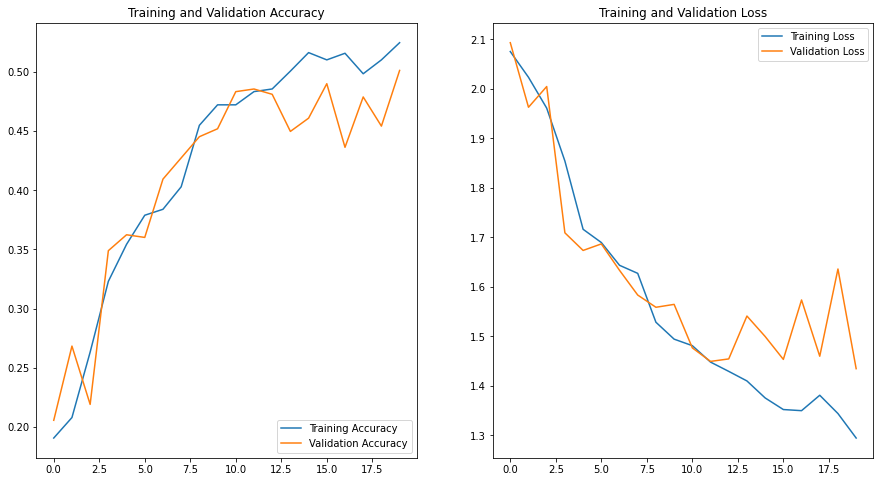

In [17]:
# Visualizing the results of augmented model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## <font color='lime'>  Observations
* Although we improved the model by avoid the overfitting, we can still see that the model is unable to learn appropriate patterns in the image.
* This is due to limited number of training data. We need to increase the training dataset so that the CNN model is able to capture important features and able to classify images with improvised accuracy.
* However, the training accuracy has significantly reduced.


--------------------------

# <font color='green'>  Examine class distribution
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

disease
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: disease, dtype: int64


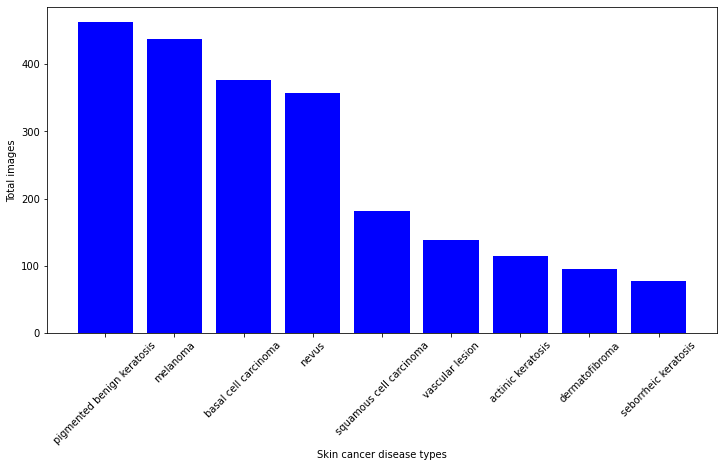

In [18]:
import glob

# Plotting the barplot for each class along with their count
def plot_disease_classes(df):
  plt.figure(figsize=(12,6))
  plt.xticks(rotation=45)
  plt.xlabel('Skin cancer disease types')
  plt.ylabel('Total images')
  plt.bar(df.keys(), df.values, color='blue')
  plt.show()

# Fetch the class names from directory and store it in dataframe along with their counts
disease_classes_1 = [os.path.basename(os.path.dirname(x)) for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
df = pd.DataFrame({'disease': disease_classes_1})
df = df.groupby('disease')['disease'].count().sort_values(ascending=False)

# Printing the keys and values of the dataframe
print (df)
plot_disease_classes(df)

## <font color='lime'>  Observations
- Which class has the least number of samples?

> 'seborrheic keratosis' with 77 images (3.4%) has the least number of sample images.

> 'dermatofibroma' (95, 4.2%), 'actinic keratosis' (114, 5.1%) and 'vascular lesion' (139, 6.2%) also have limited samples.

- Which classes dominate the data in terms proportionate number of samples?

> 'pigmented benign keratosis' (462, 20.6%) and 'melanoma'(438, 19.6) samples dominate the dataset.

> 'nevus'(357, 15.9%) and 'basal cell carcinoma'(376, 16.8%) also have a large proportion of samples.


# <font color='green'> Rectifying the class imbalance using augmentor
#### Using a python package `Augmentor` to add more samples across all classes so that none of the classes have very few samples.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [19]:
# Install Augmentor package
!pip install Augmentor

In [20]:
# Define the path to Train dataset
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# Import Augmentor package
import Augmentor

# For each of the class names, create 500 samples of augmented data
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7C208E3E10>: 100%|██████████| 500/500 [00:22<00:00, 21.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7C20772090>: 100%|██████████| 500/500 [00:24<00:00, 20.50 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7C9A65D910>: 100%|██████████| 500/500 [00:24<00:00, 20.35 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7C207B88D0>: 100%|██████████| 500/500 [01:47<00:00,  4.66 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F7C20840250>: 100%|██████████| 500/500 [01:54<00:00,  4.38 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7C20882210>: 100%|██████████| 500/500 [00:20<00:00, 23.98 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7C207A7810>: 100%|██████████| 500/500 [00:51<00:00,  9.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D31C41450>: 100%|██████████| 500/500 [00:20<00:00, 23.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7C1FEC6DD0>: 100%|██████████| 500/500 [00:23<00:00, 21.44 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [21]:
# Printing total number of image samples
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


# <font color='green'> Distribution of augmented data after adding new images to the original training data.

6739
disease
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: disease, dtype: int64


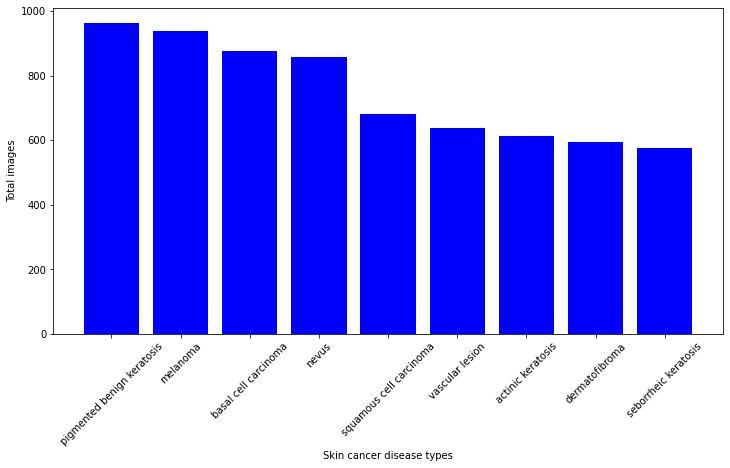

In [22]:
data_dir_train = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
print (len(list(data_dir_train.glob('**/*.jpg'))))

# Checking the images obtained by Augmentor in the output directory
disease_classes_2 = [os.path.basename(os.path.dirname(os.path.dirname(x))) for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
df = pd.DataFrame({'disease': disease_classes_1 + disease_classes_2})
df = df.groupby('disease')['disease'].count().sort_values(ascending = False)
# Printing the keys and values of the dataframe
print (df)
plot_disease_classes(df)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## <font color='lime'>  Observations

- Classes with very less samples :-

> 'seborrheic keratosis' has increased from 3.4% to 8.6%

>'dermatofibroma' has increased from 4.2% to 8.8%

> 'actinic keratosis' has increased from 5.1% to 9.1%

> 'vascular lesion' has increased from 6.2% to 9.5%

- Classes dominating the data :-

> 'pigmented benign keratosis' has reduced from 20.6% to 14.3%

> 'melanoma' has reduced from 19.6 to 13.9%

> 'basal cell carcinoma' has reduced from 16.8% to 13%

> 'nevus' has reduced from 15.9% to 12.7%

#**<font color='red'> Model 3** 

# <font color='green'> Train the model on the data created using Augmentor

In [23]:
batch_size = 32
img_height = 180
img_width = 180

# <font color='green'> Create a training & validation dataset

In [24]:
# Create train set
train_ds = image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Create validation set
val_ds = image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# <font color='green'> Creating CNN model

In [25]:
# Creating a modified model with 5 convolution layers 
# each followed by a max-pooling layer
# fully-connected layers at the end

model = keras.Sequential()
model.add(normalisation_layer)

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# <font color='green'> Model compiling

In [26]:
# Using adam optimiser to compile the model
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

# <font color='green'> Model training

In [27]:
epochs = 30

# Fitting the model with 30 epochs each with batch_size of 32
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True
)

Epoch 1/30
169/169 [==============================] - 44s 248ms/step - loss: 2.0812 - accuracy: 0.1931 - val_loss: 1.9679 - val_accuracy: 0.2725
Epoch 2/30
169/169 [==============================] - 31s 177ms/step - loss: 1.8355 - accuracy: 0.2876 - val_loss: 1.7801 - val_accuracy: 0.3630
Epoch 3/30
169/169 [==============================] - 32s 186ms/step - loss: 1.6119 - accuracy: 0.3741 - val_loss: 1.6333 - val_accuracy: 0.3593
Epoch 4/30
169/169 [==============================] - 30s 171ms/step - loss: 1.5081 - accuracy: 0.4114 - val_loss: 1.6043 - val_accuracy: 0.3942
Epoch 5/30
169/169 [==============================] - 30s 174ms/step - loss: 1.4018 - accuracy: 0.4509 - val_loss: 1.7280 - val_accuracy: 0.3727
Epoch 6/30
169/169 [==============================] - 31s 175ms/step - loss: 1.3183 - accuracy: 0.4894 - val_loss: 1.8138 - val_accuracy: 0.3504
Epoch 7/30
169/169 [==============================] - 31s 175ms/step - loss: 1.2373 - accuracy: 0.5191 - val_loss: 1.3697 - val_ac

# <font color='green'> Data Visualization

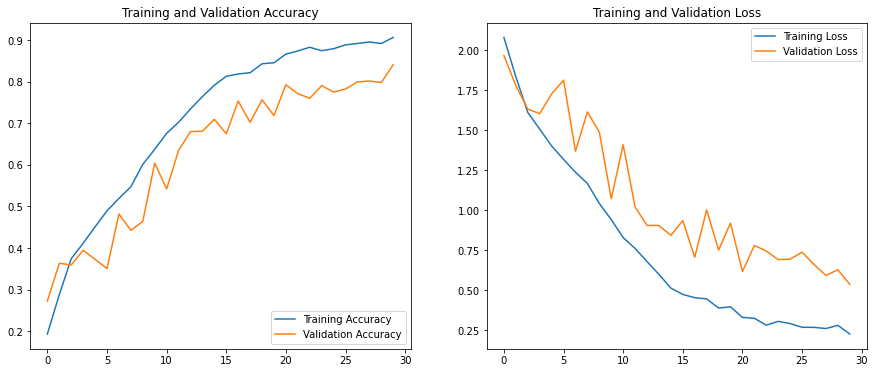

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## <font color='lime'>  Observations
* With more number of training samples, the modified model is able to get a better accuracy as compared to the previous models.
* We also got rid of overfitting and underfitting of the model



#**<font color='red'> Test Predictions**

##### We will get the images from test directory and evaluate the final model to calculate the accuracy

In [29]:
# Fetch test data
test_ds = image_dataset_from_directory(
    data_dir_test,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size
)
print(test_ds.class_names)

model.evaluate(test_ds)

Found 118 files belonging to 9 classes.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
4/4 [==============================] - 4s 104ms/step - loss: 3.9561 - accuracy: 0.4068


[3.9561378955841064, 0.4067796468734741]